# `neuscitk`

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import neuscitk.neuscitk as ntk

# Loading and Organizing Data with `LabChartDataset`

`LabChartDataset` Methods
1. `fs`
2. `n_channels`
2. `get_block`
3. `organize_by_pages`
4. `get_page`
5. `concat_blocks`

In [4]:
dataset = ntk.LabChartDataset('./assets/datasets/cockroach_lab.mat')

In [5]:
print(dataset.fs)

40000.0


In [6]:
print(dataset.n_channels)

3


If we would like to access one of our recordings we can do that with the `get_block` method. `get_block` can take either a single integer or a list/array of integers as its input. If you give it a single integer, it will return to you an array with shape `(n_channels, length_of_recording)`. If you give it a list/array of integers, it will return to you a dictionary with the blocks you gave it as its values.

In [7]:
block_0 = dataset.get_block(0)
print(block_0.shape)
# print(block_0)

(3, 400000)


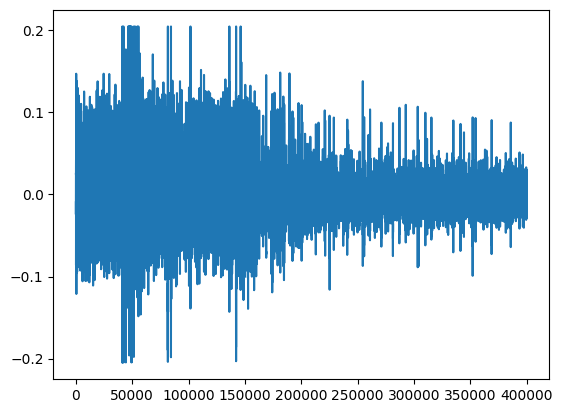

In [8]:
block_0_ch1 = block_0[0]
plt.plot(block_0_ch1)
plt.show()

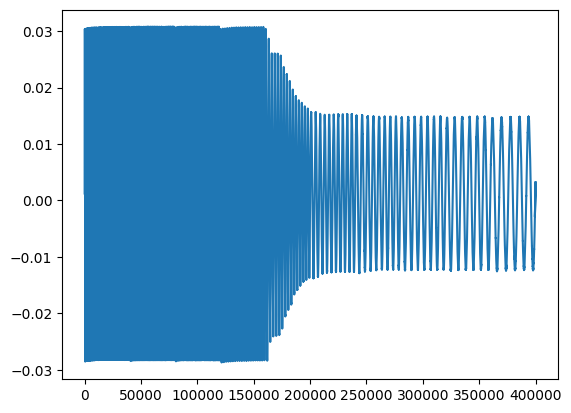

In [9]:
block_0_ch2 = block_0[1]
plt.plot(block_0_ch2)
plt.show()

In [12]:
first_10_blocks = dataset.get_block(np.arange(10))
print(first_10_blocks.keys())

dict_keys(['block_0', 'block_1', 'block_2', 'block_3', 'block_4', 'block_5', 'block_6', 'block_7', 'block_8', 'block_9'])


In [13]:
print(first_10_blocks['block_0'].shape)

(3, 400000)


### **Question**: if my array has shape `(3, 4000000)` and my sample rate is 40kHz, how long is my recording in seconds?

In LabChart, you have the ability to organize your data into pages and subpages. Unfortunately, this information does not get exported when we convert our data to the `.mat` format. Instead, LabChart gives us one *really* long array for each channel, and the start and stop times for the different recordings. When you create an instance of `LabChartDataset` this array is organized into individual recordings according to those start and stop times, but there still is not information about the pages.

However, if you want to organize your data into the pages you collected you can still do that by using the `organize_by_pages` method. To do this we first need to create a page map, which is just a dictionary where the keys are the names of our pages, and the values are the blocks.

In [14]:
page_map = {
    'frequency ramp 1' : np.arange(10),
    'amplitude ramp 1' : np.arange(10, 20),
    'amplitude chirp 1' : np.arange(20, 30),
    'white noise 1' : np.arange(30, 40),
    'frequency chirp 1' : np.arange(40, 50),
    'frequency ramp 2' : np.arange(50, 60),
    'amplitude ramp 2' : np.arange(60, 70),
    'frequency chirp 2' : np.arange(70, 80)
}

dataset.organize_by_pages(page_map)

In [ ]:
freq_ramp_1 = dataset.get_page('frequency ramp 1')
freq_ramp_1

What if we wanted to get a group of blocks but combine them? You could do this manually, but `LabChartDataset` comes with a method to do this built in, `concat_blocks`

In [17]:
first_10_combined = dataset.concat_blocks(np.arange(10))
print(first_10_combined.shape)

(3, 4000000)


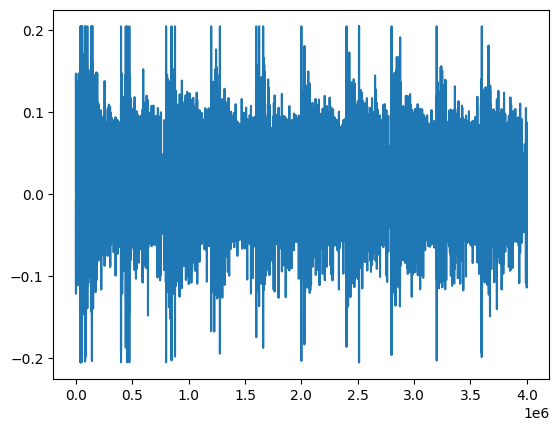

In [21]:
plt.plot(first_10_combined[0])
plt.show()

# Spike sorting with `ntk.sort_spikes`

When we obtain extracellular recordings our electrodes typically detect spikes from more than one neuron. Each neuron encodes information differently, and so ideally we would like to isolate signals from different neurons. We also have the additional challenge of "background noise"

### How can we distinguish spikes from different neurons? We can use their waveform shape!

For many reasons including cell size and distance from the electrode, different neurons have different action potential waveforms in our recordings. We can use these differences to effectively attribute waveforms to individual neurons, with some caveats.

In `neuscitk` spike sorting your data is as simple as calling a function, but it is extremely *important* to assess the results manually. In order to adjust the results effectively it is important to understand roughly how the algorithm works under the hood. But before we talk about that let's just see what it looks like.

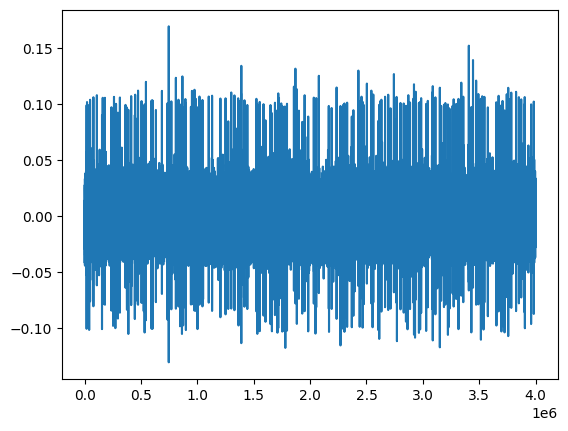

In [22]:
spontaneous_data = dataset.concat_blocks(np.arange(-10, 0))
spontaneous_ch1 = spontaneous_data[0]

plt.plot(spontaneous_ch1)
plt.show()

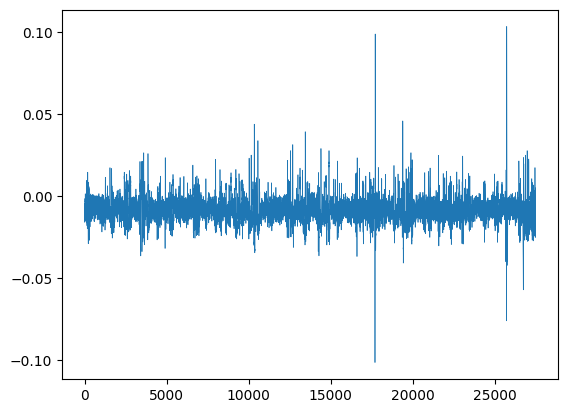

In [23]:
plt.plot(spontaneous_ch1[22500:50000], lw=0.5)
plt.show()

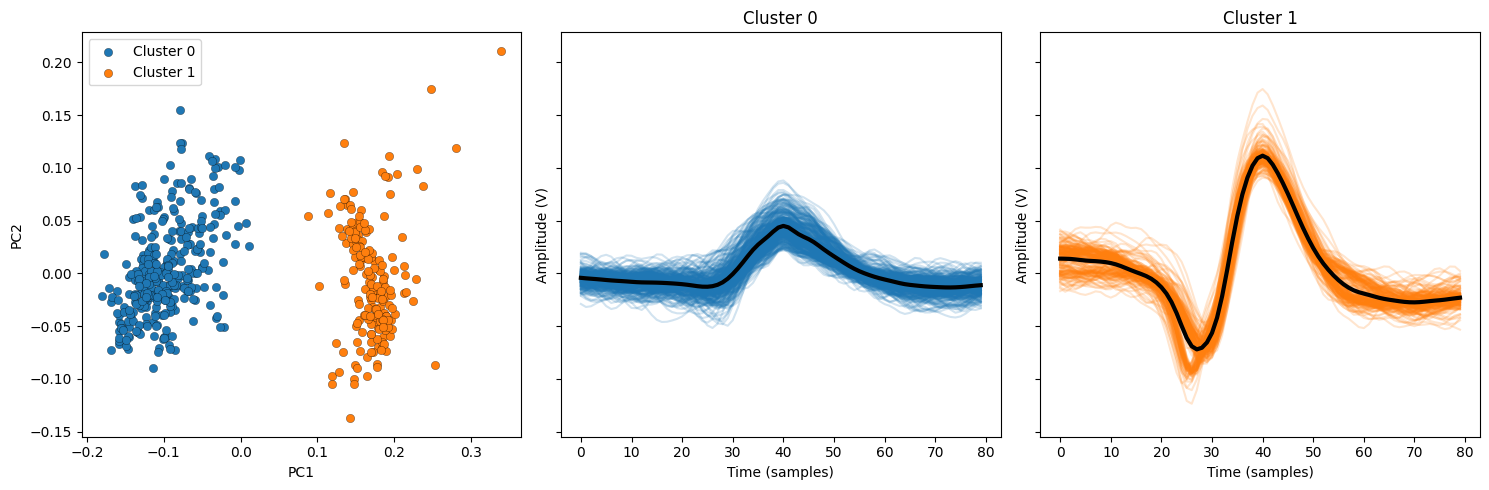

In [24]:
sorted_spikes = ntk.sort_spikes(spontaneous_ch1, dataset.fs)
sorted_spikes.plot_clusters()

Woah! Don't worry if you don't understand what the image on the left is, we'll get there soon.

In `neuscitk` the spike sorting algorithm follows this pipeline:

1. Filtering
2. Adaptive thresholding
3. Waveform extraction
4. Dimensionality reduction
5. Clustering

Each one of these steps has parameters. Changing the parameters can change your results significantly so let's talk briefly about each step.


### 1. Filtering
- The first step in our algorithm is some simple preprocessing. We apply a 4th order band pass filter (lowpass and highpass) at 100 and 9000 Hz
- The high pass filter effectively centers our data, removing any constant offset from 0V
- The low pass filter removes the most extreme "noise" in our data. It has a smaller effect than the high pass but can help to remove high frequency artifacts.
- This step is associated with 3 parameters `lowcut`, `highcut` and `order`
- I wouldn't really recommend playing with these parameters

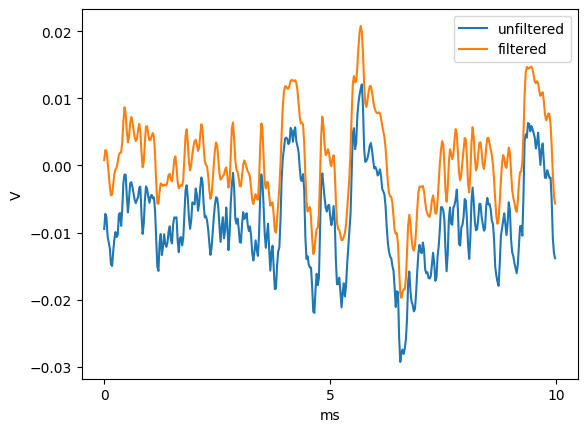

In [30]:
filtered_spontaneous = ntk.apply_band_pass(spontaneous_ch1, dataset.fs, 100, 9000)
plt.plot(spontaneous_ch1[:400], label='unfiltered')
plt.plot(filtered_spontaneous[:400], label='filtered')
plt.xticks([0, 200, 400], [0, 5, 10])
plt.legend()
plt.xlabel('ms')
plt.ylabel('V')
plt.show()

### 2. Adaptive thresholding
- After cleaning up our data with filtering, we need to detect spikes. To do this we compute a moving standard deviation of our spikes.
- What is a moving standard deviation? Let's start by discussing a moving average

In [31]:
window_size = 0.01
moving_avg = ntk.moving_average(filtered_spontaneous, dataset.fs, window_size)
moving_std = ntk.moving_std(filtered_spontaneous, dataset.fs, window_size)

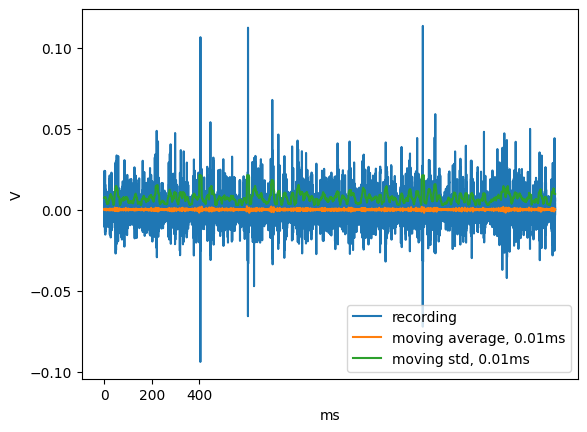

In [32]:
plt.plot(filtered_spontaneous[24000:100000], label='recording')
plt.plot(moving_avg[24000:100000], label=f'moving average, {window_size}ms')
plt.plot(moving_std[24000:100000], label=f'moving std, {window_size}ms')
plt.xticks([0, 8000, 16000], [0, 200, 400])
plt.xlabel('ms')
plt.ylabel('V')
plt.legend()
plt.show()

- To construct a threshold from the moving std we can define a multiplier, and say that we detect a spike at time point $t$ if our recording is greater than our moving average times the multiplier at time point $t$

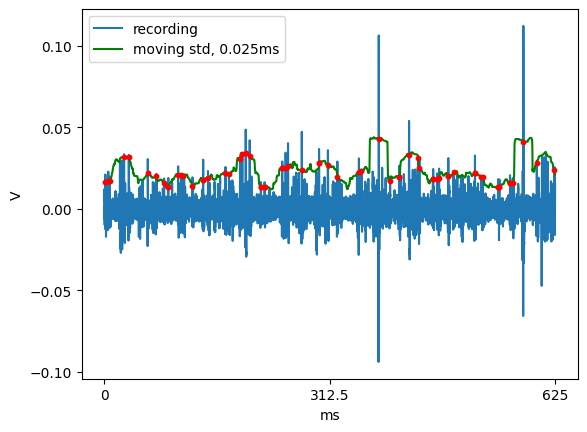

In [50]:
# define multiplier and detect spikes
window_size = 0.025
moving_std = ntk.moving_std(filtered_spontaneous[25000:50000], dataset.fs, window_size)
multiplier = 3
spike_times = ntk.detect_spikes(filtered_spontaneous[25000:50000], dataset.fs, window_size, multiplier)

plt.plot(filtered_spontaneous[25000:50000], label='recording')
plt.plot(multiplier * moving_std, label=f'moving std, {window_size}ms', c='g')  # Adjusted slicing
plt.scatter(spike_times, multiplier * moving_std[spike_times - 25000], c='red', s=10, zorder=10)  # Adjusted indexing
plt.xticks([0, 12500, 25000], [0, 312.5, 625])
plt.xlabel('ms')
plt.ylabel('V')
plt.legend()
plt.show()

In [51]:
print(spike_times)

[   65   227   234   308  1102  1363  2416  2890  3322  3549  3554  4100
  4263  4348  4895  5484  5488  5754  6724  6916  7530  7657  7845  8067
  8681  8686  8890  8895  9865  9871 10058 10191 10954 11912 11915 12403
 12928 14122 14264 15221 15851 16358 16364 16901 17400 17473 18223 18240
 18473 18481 18567 19071 19078 19369 20551 20556 20912 20991 21828 21834
 21906 21911 22499 22505 22650 23240 23982 24964]


- Changing the multiplier as well as the size of your window can have a very large effect on the spike sorting quality
- The `sort_spikes` parameters associated with this step are `ma_window` and `threshold multiplier`

### 3. Extract waveforms

- After calculating the spike times we now need to go into our recording and actually get our waveforms
- To do this we need to set a length of time before and after our peak to extract. A good starting place is 3ms

In [52]:
ap_window_size = int(dataset.fs / 1000) * 3
ap_waveforms = ntk.extract_waveforms(filtered_spontaneous[25000:50000], dataset.fs, spike_times, ap_window_size)
print(ap_waveforms.shape)

(47, 120)


- `ap_waveforms` has shape `(num_spikes, ap_window_size)`
- Let's take a look at our waveforms

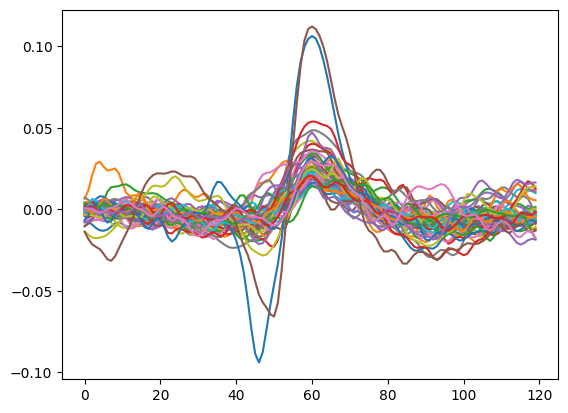

In [53]:
for wf in ap_waveforms:
    plt.plot(wf)

- Nice! looks like we have at least two and potentially more neurons! It isn't immediately obvious how changing the window size does anything but change our visualization but it can play a crucial role in the next step
- This step has one parameter `waveform_window`

### 4. Dimensionality reduction
- Dimensionality reduction refers to a group of statistical techniques which aim to summarize high dimensional data in a lower dimensional space, whilst preserving as much structure, or information from the original data as possible

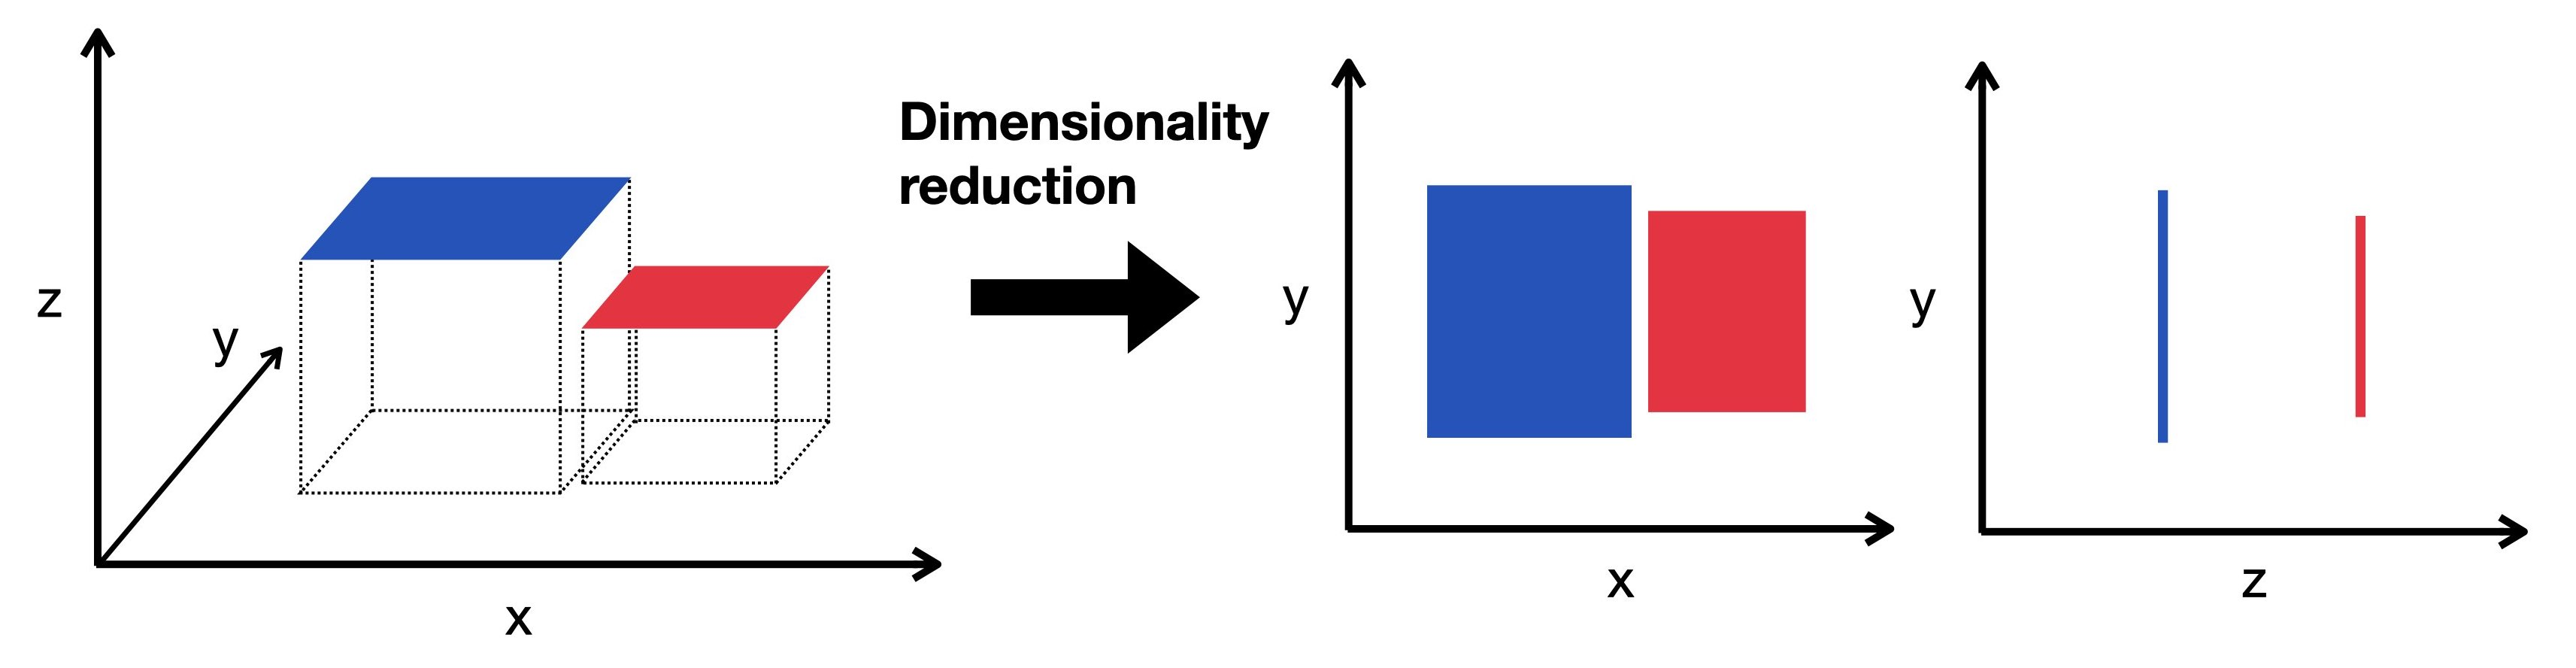

- But what is high dimensional data? Action potential waveforms! But action potential waveforms are just lines? Aren't lines 1-dimensional?

- The most commonly used dimensionality reduction technique, and the one we use in this class is Principal Components Analysis or PCA

- Beyond spike sorting, in the last 15 years dimensionality reduction has become an increasingly important technique in neuroscience. For example, researchers who collect multi channel data from populations of neurons will often perform PCA on their data to reveal really beautiful structure that you can't see if you just look at the firing rates of all the single units.

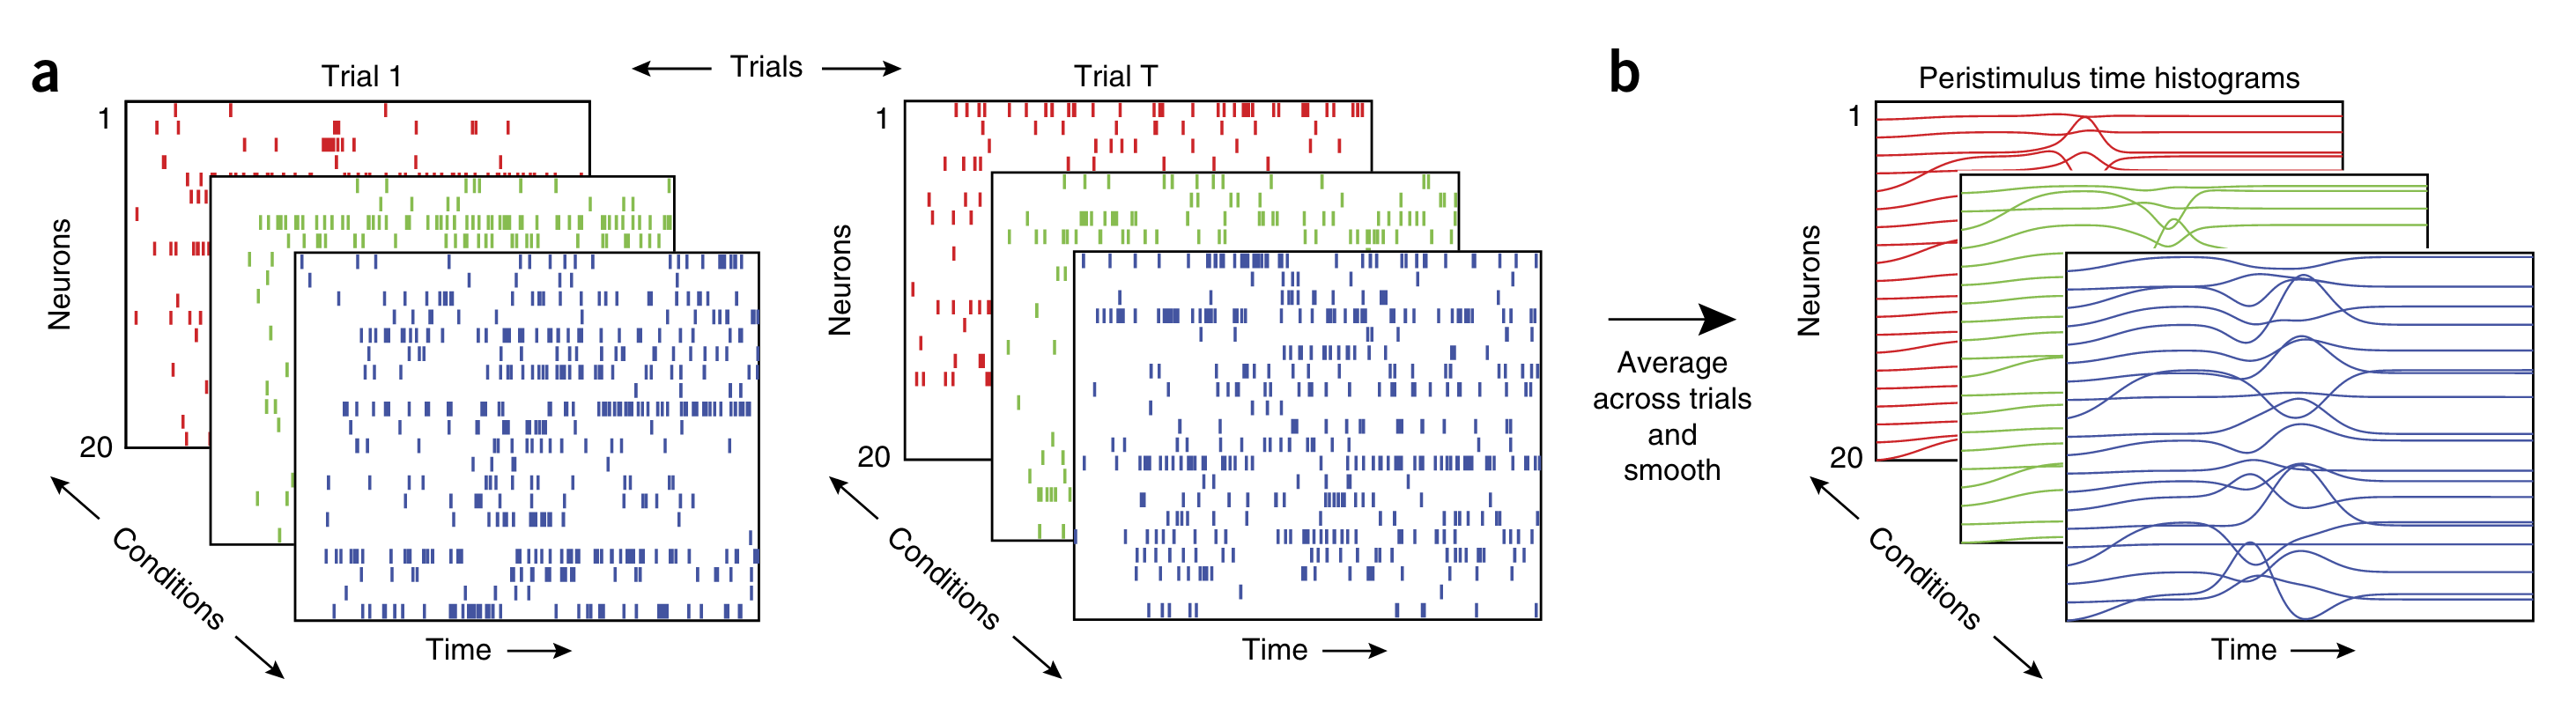
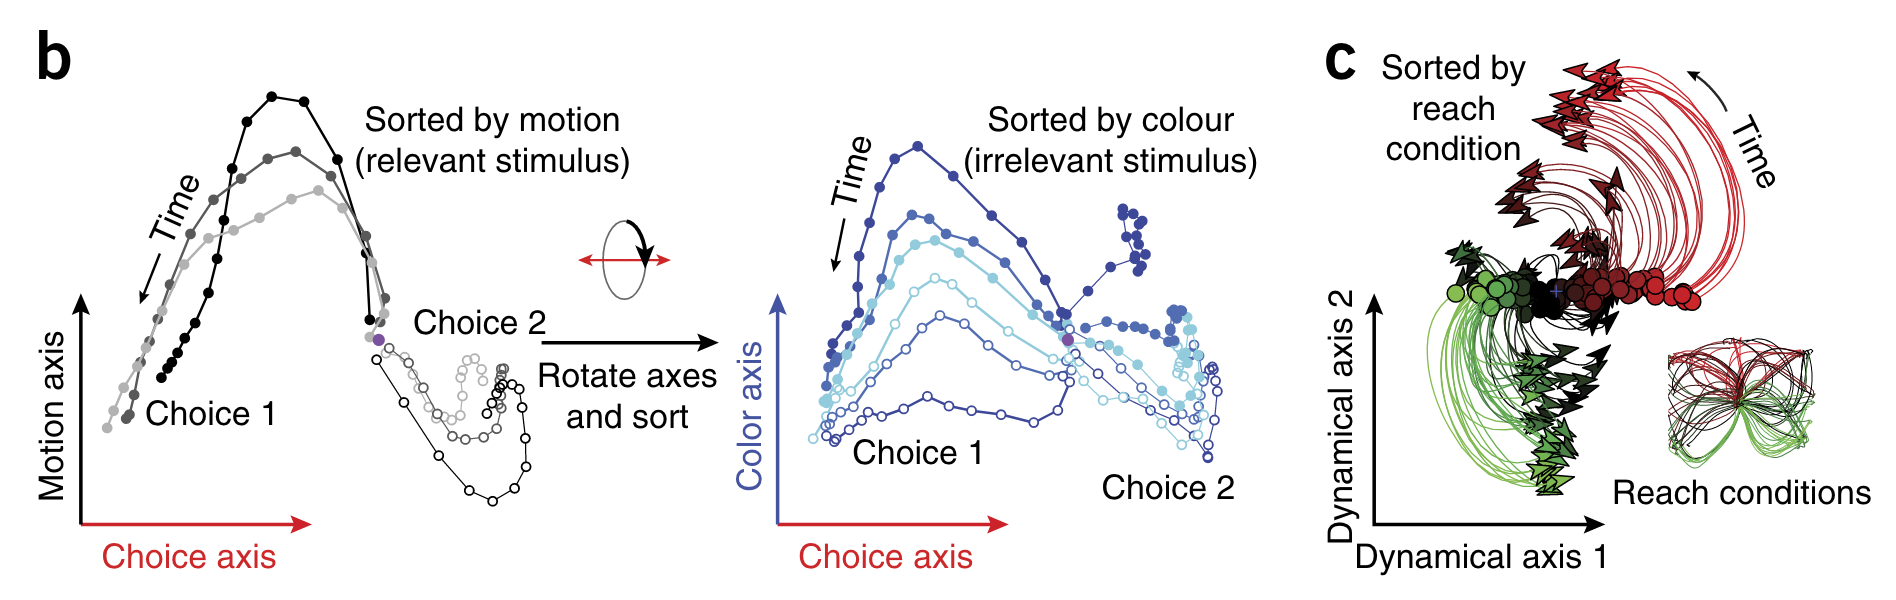

- How are we going to use PCA? 120 dimensions is a lot, and we don't need all of those axes of variation to describe the differences between our two groups of action potentials. PCA will find a *projection* of our waveforms into a lower dimensional space that tries to retains as much information from the 120 dimensions as possible.
- If two waveforms look similar plotted as a line, they will be close in the 2d space after PCA.

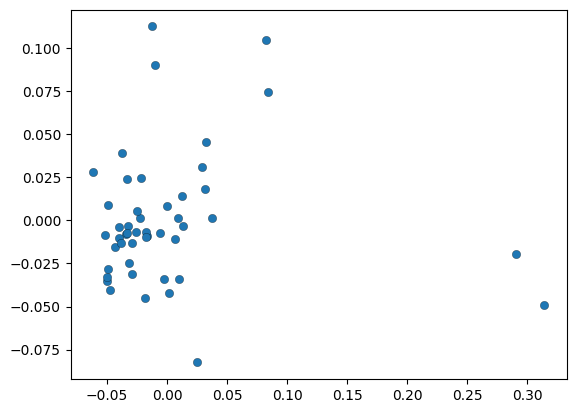

In [54]:
pca_embedding = ntk.perform_pca(ap_waveforms, 2)
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], edgecolors='black', linewidths=0.2)
plt.show()

- PCA doesn't just make it easier to visualize similarities in our waveforms, but it also makes the next step in our spike sorting algorithm easier. PCA doesn't force us to project into 2d. We can keep as many dimensions as we want, and the more we keep the more information about the original waveforms we keep as well.
- How many dimensions you keep is the parameter for this step, `cluster_dimensions`, and although we will want to project it into 2d when we visualize. We usually will want more than that for the next step.

### 5. Clustering
- Clustering is a family of problems and techniques in statistics for grouping unlabeled data into categories

- Clustering algorithms leverage patterns and structure in our data to assign discrete labels to individual data points

- In our case we have a group of 2d points which represent our action potential waveforms and we want to group them together. We hope that these groups represent the waveforms from our individual neurons

- We could have had 3d or 4d or 10d points if we had kept more of our dimensions.

- To cluster our data we will use a simple and very commonly applied algorithm called KMeans clustering

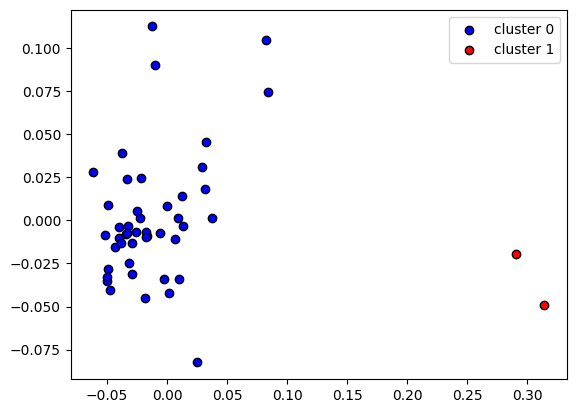

In [55]:
labels = ntk.cluster_points(pca_embedding, 2)

plt.scatter(pca_embedding[labels == 0, 0], pca_embedding[labels == 0, 1], c='b', edgecolors='black', label='cluster 0')
plt.scatter(pca_embedding[labels == 1, 0], pca_embedding[labels == 1, 1], c='r', edgecolors='black', label='cluster 1')
plt.legend()
plt.show()

- So cool!

- Clustering doesn't always work like you might think. Depending on how many dimensions you keep from PCA, the clusters may look overlapping in the 2d space. This is because we can't see the full picture! Likely our data is closer along some depth axis that we can't see. This will definetely come up in your data and we will talk about it more.

- KMeans is also not a deterministic algorithm, meaning that if we run it again we could get slightly different results. Usually this is just the cluster number switching, but with more complicated data we might find different clusters. We'll talk about how to deal with this later.

- We also can tune the number of clusters we want with the `n_clusters` parameter

- If you want to learn more about clustering and KMeans you can checkout my [blog post](https://jeremyschroeter.com/2024/04/15/kmeans_gmm.html)

Whew! That was kind of a lot. Let's see how good our algorithm did. We can use the labels that KMeans gave back to us to index into our waveforms array and plot them separately.

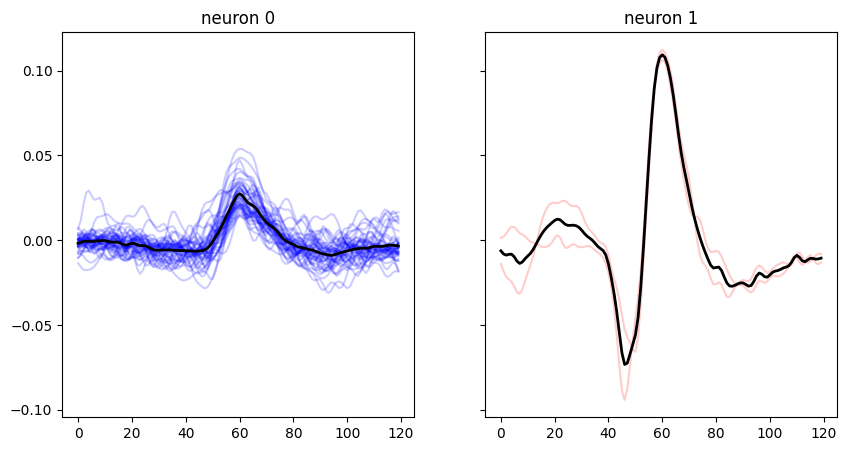

In [56]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax[0].plot(ap_waveforms[labels == 0].T, c='b', alpha=0.2)
ax[0].plot(ap_waveforms[labels == 0].mean(0), c='black', lw=2)
ax[0].set_title('neuron 0')
ax[1].plot(ap_waveforms[labels == 1].T, c='r', alpha=0.2)
ax[1].plot(ap_waveforms[labels == 1].mean(0), c='black', lw=2)
ax[1].set_title('neuron 1')
plt.show()

Amazing! Whenever you call `ntk.sort_spikes` all of this is happening under the hood to give you back your spikes. You can change any of the parameters, but the default values should be a good place to start. In my experience the most finicky ones are the threshold multiplier, so it might not be a bad idea to make the plots we did earlier of the moving std and your data to make sure you are capturing all the neurons you want. The number of clusters can also be finnicky and we will talk about how to deal with that later.

Let's go back now and talk about our spike sorting results from earier.

# `SortedSpikes`

## Methods
1. `plot_clusters`
2. `get_cluster_waveforms`
3. `get_cluster_spike_times`
4. `recluster`
5. `hand_pick_clusters`
6. `pca_embeddings`
7. `labels`

When we use `ntk.sort_spikes` we have to assign its outputs a `SortedSpikes` object. This object comes with a bunch of methods for you to access your waveforms, and spike times, and make slight adjustments to the spike sorting results. Maybe the most important of these methods is `plot_clusters`. This is how we can visualize and assess our results.



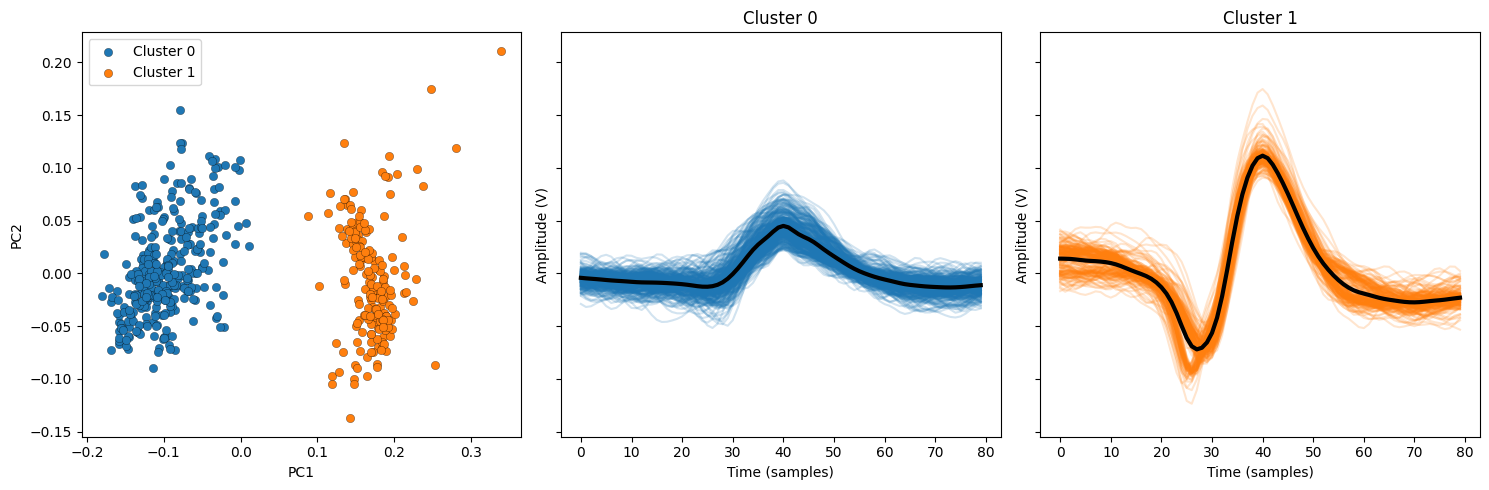

In [57]:
sorted_spikes = ntk.sort_spikes(spontaneous_ch1, dataset.fs)
sorted_spikes.plot_clusters()

**Please** do not use these figures for your lab reports. This is just a visualization tool. You should be making your own custom figures that serve your lab report.

If we want to get the waveforms from one of our groups we can use the `get_cluster_waveforms` method. This will return back an array of shape `(n_spikes, waveform_window)` that contains all of our waveforms.

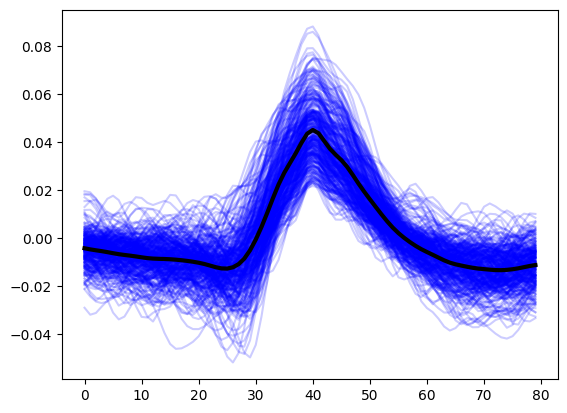

In [59]:
cluster0_wfs = sorted_spikes.get_cluster_waveforms(0)

for wf in cluster0_wfs:
    plt.plot(wf, c='b', alpha=0.2)
plt.plot(cluster0_wfs.mean(0), c='black', lw=3)
plt.show()

Of course you don't have to just display these, you can also use them to calculate features like half-width and mean amplitude, etc. 

If we want to get our spike times we can use the `get_cluster_spike_times` method. This will return back to us an array with shape `(n_spikes,)` that has the sample of when our waveforms peak occured.

In [60]:
cluster0_spike_times = sorted_spikes.get_cluster_spike_times(0)
print(cluster0_spike_times)

[   4095    6830   20380   35954   53352   55675   59763   74120   86951
   88010   95780  113482  127665  134394  144508  149550  156060  168730
  169728  186364  194372  201832  204746  205804  219758  224278  250987
  254364  256085  262408  329313  370068  374558  377635  381294  404979
  407178  407729  415610  432407  444251  474997  478058  481263  485025
  507854  556455  579003  604539  605106  629630  640649  660771  670834
  689082  714180  718998  724995  730830  768232  776114  776759  797606
  811536  813939  827694  835984  872634  897074  901619  905726  931557
  951546  955635  956231  960397 1036677 1053993 1080300 1090347 1114738
 1129049 1135861 1147438 1156317 1182682 1199753 1206963 1225208 1229924
 1237307 1244242 1285388 1299657 1304685 1309875 1312094 1312815 1317304
 1338423 1345467 1352651 1379642 1391298 1399332 1406901 1408019 1432655
 1433864 1452381 1481240 1499614 1501964 1512111 1534426 1566766 1572195
 1572776 1601379 1613881 1644348 1667652 1673572 16

Let's take a look at that other cluster.

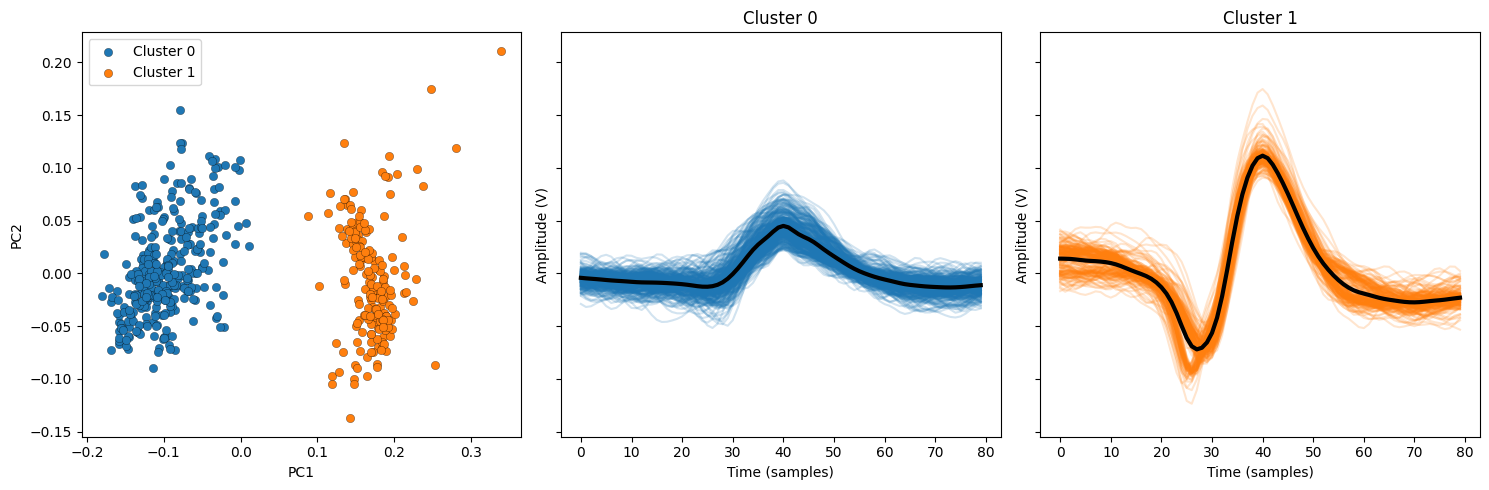

In [61]:
sorted_spikes.plot_clusters()

To my eye, many of the waveforms assigned to cluster 1 don't line up with the others. Let's try and see if we can get KMeans to recognize that group of waveforms. To do so we can use the `recluster` method, which will run KMeans again on the PCA embeddings, but we can set the cluster number this time. The method will update everything in the background, so we'll have to visualize the results again after running it.

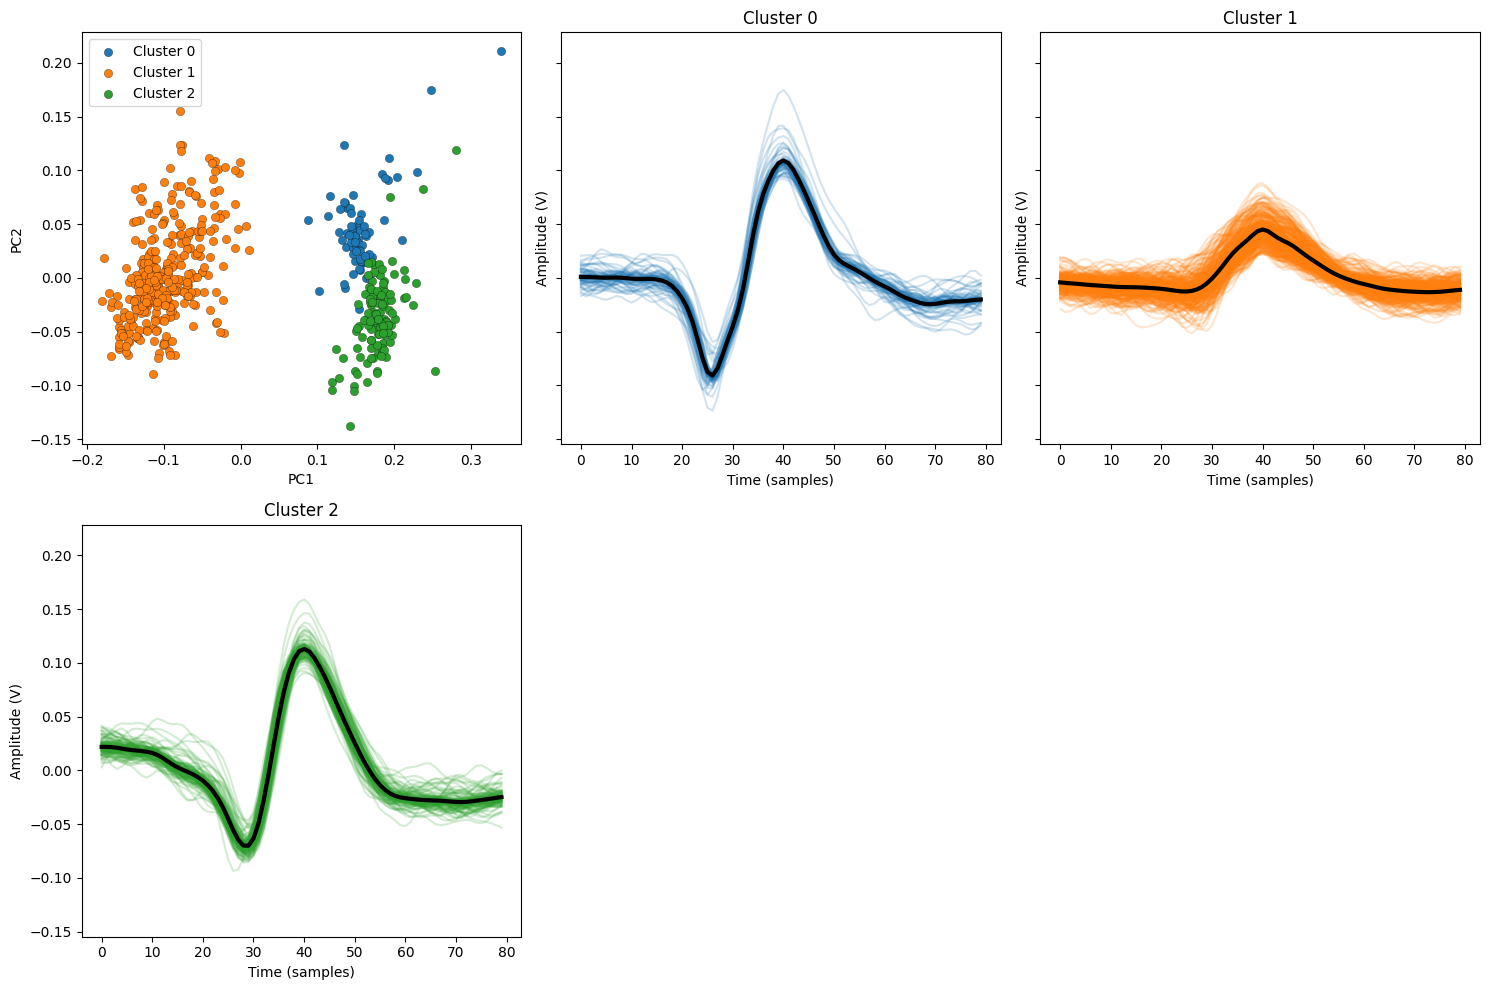

In [65]:
sorted_spikes.recluster(3)
sorted_spikes.plot_clusters()

Amazing. Finally if you really want to you are also able to handpick your clusters. I recommend avoiding this if you can because it is error prone, and we can't see all the PCA dimensions that KMeans can. To handpick your clusters you can use the `hand_pick_clusters` method, which also will update everything under the hood.

In [66]:
sorted_spikes.hand_pick_clusters()

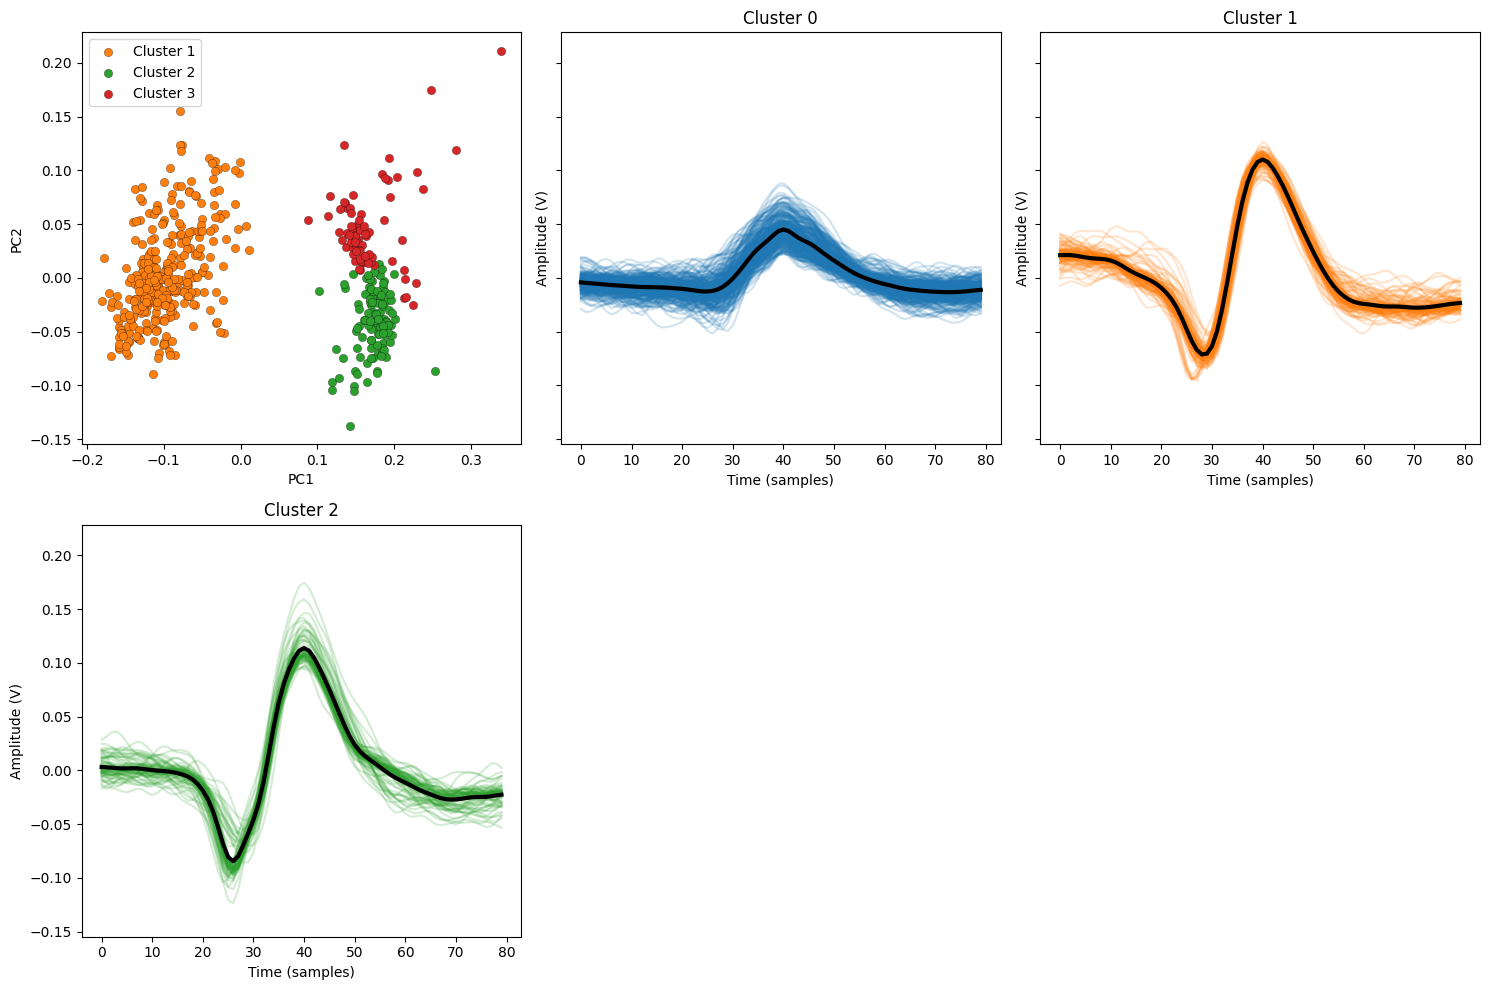

In [67]:
sorted_spikes.plot_clusters()

Now try on your own data!

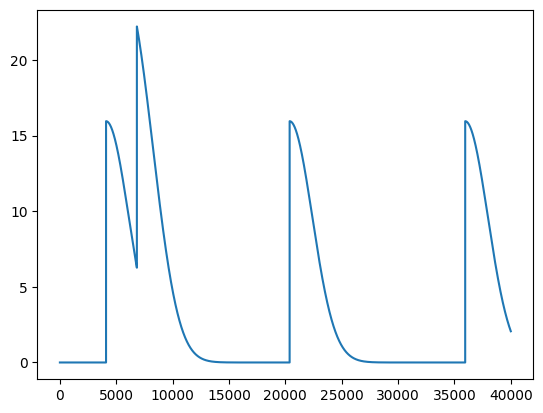

In [69]:
spike_train = sorted_spikes.get_spike_train(0)
firing_rate_converter = ntk.FiringRateConverter(dataset.fs)
smoothed = firing_rate_converter.apply(spike_train)

In [ ]:
plt.plot(smoothed[:40000])